# License Plate Detection

## Downloading the dataset

In [1]:
from datasets import load_dataset
ds = load_dataset("keremberke/license-plate-object-detection", name="full")
example = ds['train'][0]
example

{'image_id': 6152,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 'width': 472,
 'height': 303,
 'objects': {'id': [6388],
  'area': [2604],
  'bbox': [[261.0, 203.0, 93.0, 28.0]],
  'category': [0]}}

## Data Processing

In [2]:
IMG_SIZE = 416
GRID_SIZE = 13
NUM_CLASSES = 1

import tensorflow as tf
import numpy as np

def utils_resize_with_pad(image, target_size):
    if not tf.is_tensor(image):
        image = tf.convert_to_tensor(image)
        
    shape = tf.cast(tf.shape(image), tf.float32)
    h, w = shape[0], shape[1]
    
    target_size_float = tf.cast(target_size, tf.float32)
    target_size_int = tf.cast(target_size, tf.int32)
    
    scale = tf.minimum(target_size_float / w, target_size_float / h)
    
    new_w = tf.cast(w * scale, tf.int32)
    new_h = tf.cast(h * scale, tf.int32)
    
    image = tf.image.resize(image, (new_h, new_w))
    
    image = tf.image.resize_with_pad(image, target_size_int, target_size_int)
    
    pad_w = (target_size_float - tf.cast(new_w, tf.float32)) / 2.0
    pad_h = (target_size_float - tf.cast(new_h, tf.float32)) / 2.0
    
    return image, scale, pad_w, pad_h

def preprocess(sample, augment=False):
    image = sample["image"]
    
    image = tf.convert_to_tensor(np.array(image))
    
    if augment:
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_saturation(image, 0.8, 1.2)


    image, scale, pad_w, pad_h = utils_resize_with_pad(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0

    target = np.zeros((GRID_SIZE, GRID_SIZE, 5), dtype=np.float32)

    boxes = sample["objects"]["bbox"]

    for box in boxes:
        x, y, w, h = box
        
        x = x * scale
        y = y * scale
        w = w * scale
        h = h * scale
        
        x += pad_w
        y += pad_h
        
        xc = (x + w / 2) / IMG_SIZE
        yc = (y + h / 2) / IMG_SIZE
        w /= IMG_SIZE
        h /= IMG_SIZE

        if w > 0 and h > 0:
            gx = int(xc * GRID_SIZE)
            gy = int(yc * GRID_SIZE)

            if 0 <= gx < GRID_SIZE and 0 <= gy < GRID_SIZE:
                target[gy, gx, 0] = 1.0        # objectness
                
                # relative
                xc_rel = xc * GRID_SIZE - gx
                yc_rel = yc * GRID_SIZE - gy
                
                target[gy, gx, 1:] = [xc_rel, yc_rel, w, h]

    return image, target

2026-01-20 10:53:13.988059: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Loading

In [3]:
BATCH_SIZE = 8

def tf_generator(split, augment=False):
    for sample in ds[split]:
        yield preprocess(sample, augment=augment)

output_signature = (
    tf.TensorSpec((IMG_SIZE, IMG_SIZE, 3), tf.float32),
    tf.TensorSpec((GRID_SIZE, GRID_SIZE, 5), tf.float32)
)

train_ds = tf.data.Dataset.from_generator(
    lambda: tf_generator("train", augment=True),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1768906397.986898    3650 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2601 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


## Model

In [4]:
from tensorflow.keras import layers, models

def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = layers.Conv2D(16, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(5, 1, activation=None)(x)
    outputs = layers.Reshape((GRID_SIZE, GRID_SIZE, 5))(x)

    return models.Model(inputs, outputs)

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 416, 416, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 416, 416, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 416, 416, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 416, 416, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 208, 208, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 208, 208, 32)   │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 208, 208, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 208, 208, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 104, 104, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 104, 104, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 104, 104, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 104, 104, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 5)      │         1,285 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 395,381 (1.51 MB)

 Trainable params: 394,389 (1.50 MB)

 Non-trainable params: 992 (3.88 KB)

## Training

In [5]:
def detection_loss(y_true, y_pred):
    obj_mask = y_true[..., 0]
    noobj_mask = 1.0 - obj_mask

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    obj_loss_map = bce(y_true[..., 0:1], y_pred[..., 0:1])
    
    obj_loss = tf.reduce_sum(obj_mask * obj_loss_map) + 0.5 * tf.reduce_sum(noobj_mask * obj_loss_map)

    box_diff = y_true[..., 1:] - tf.sigmoid(y_pred[..., 1:])
    box_loss_map = tf.reduce_sum(tf.square(box_diff), axis=-1)
    
    box_loss = tf.reduce_sum(obj_mask * box_loss_map)
    
    batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
    
    return (obj_loss + 5.0 * box_loss) / batch_size

In [6]:
model = build_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=detection_loss
)

history = model.fit(train_ds, epochs=10)

# Save the model
model.save("license_plate_detector.keras")

Epoch 1/10


2026-01-20 10:53:31.926857: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fbe44004080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-20 10:53:31.926886: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2026-01-20 10:53:32.023246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-20 10:53:32.458265: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2026-01-20 10:53:35.067566: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-20 10:53:35.288338: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed ou

      2/Unknown 10s 56ms/step - loss: 71.4042

I0000 00:00:1768906419.238988    4113 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


772/772 ━━━━━━━━━━━━━━━━━━━━ 203s 250ms/step - loss: 2.6179
Epoch 2/10


2026-01-20 10:56:52.346303: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-01-20 10:56:52.346342: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2026-01-20 10:56:52.346359: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2446394132054480579
2026-01-20 10:56:52.346390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8138982463001371182
/home/alex/afs/Master/DNN/project_dnn/.venv/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repea

772/772 ━━━━━━━━━━━━━━━━━━━━ 189s 245ms/step - loss: 1.2221
Epoch 3/10


2026-01-20 11:00:01.513544: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2026-01-20 11:00:01.513572: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2446394132054480579
2026-01-20 11:00:01.513588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8138982463001371182


772/772 ━━━━━━━━━━━━━━━━━━━━ 192s 248ms/step - loss: 0.9868
Epoch 4/10


2026-01-20 11:03:13.089483: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2446394132054480579
2026-01-20 11:03:13.089526: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8138982463001371182


772/772 ━━━━━━━━━━━━━━━━━━━━ 196s 254ms/step - loss: 0.8370
Epoch 5/10


2026-01-20 11:06:28.930940: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2026-01-20 11:06:28.930978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2446394132054480579
2026-01-20 11:06:28.931014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8138982463001371182


772/772 ━━━━━━━━━━━━━━━━━━━━ 199s 258ms/step - loss: 0.6956
Epoch 6/10


2026-01-20 11:09:48.082620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2446394132054480579
2026-01-20 11:09:48.082666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8138982463001371182


772/772 ━━━━━━━━━━━━━━━━━━━━ 191s 247ms/step - loss: 0.6113
Epoch 7/10


2026-01-20 11:12:59.066463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2446394132054480579
2026-01-20 11:12:59.066492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8138982463001371182


772/772 ━━━━━━━━━━━━━━━━━━━━ 195s 253ms/step - loss: 0.4935
Epoch 8/10


2026-01-20 11:16:14.428075: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2446394132054480579
2026-01-20 11:16:14.428108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8138982463001371182


772/772 ━━━━━━━━━━━━━━━━━━━━ 195s 253ms/step - loss: 0.4317
Epoch 9/10


2026-01-20 11:19:29.908743: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2026-01-20 11:19:29.908781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2446394132054480579
2026-01-20 11:19:29.908799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8138982463001371182


772/772 ━━━━━━━━━━━━━━━━━━━━ 202s 262ms/step - loss: 0.3639
Epoch 10/10


2026-01-20 11:22:51.783383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2446394132054480579
2026-01-20 11:22:51.783424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8138982463001371182


772/772 ━━━━━━━━━━━━━━━━━━━━ 202s 262ms/step - loss: 0.3048


2026-01-20 11:26:13.823744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2446394132054480579
2026-01-20 11:26:13.823792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8138982463001371182


# Inference test

In [7]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

OBJ_THRESHOLD = 0.5 

def infer_single_image(model, sample, expand_box_ratio=0.15):

    image = sample["image"]
    
    img_tensor, scale, pad_w, pad_h = utils_resize_with_pad(image, IMG_SIZE)
    img_tensor = tf.cast(img_tensor, tf.float32) / 255.0

    pred = model(tf.expand_dims(img_tensor, 0), training=False)

    obj = tf.sigmoid(pred[0, ..., 0])
    box = tf.sigmoid(pred[0, ..., 1:5])

    max_idx = tf.argmax(tf.reshape(obj, [-1]))
    gy = max_idx // GRID_SIZE
    gx = max_idx % GRID_SIZE
    
    gy = int(gy)
    gx = int(gx)
    pad_w = float(pad_w)
    pad_h = float(pad_h)
    scale = float(scale)

    confidence = obj[gy, gx].numpy()

    if confidence < OBJ_THRESHOLD:
        return image, None, confidence

    x_rel, y_rel, w, h = box[gy, gx].numpy()

    xc = (gx + x_rel) / GRID_SIZE
    yc = (gy + y_rel) / GRID_SIZE
    
    xc_px = xc * IMG_SIZE
    yc_px = yc * IMG_SIZE
    w_px = w * IMG_SIZE
    h_px = h * IMG_SIZE
    
    xc_px -= pad_w
    yc_px -= pad_h
    
    xc_orig = xc_px / scale
    yc_orig = yc_px / scale
    w_orig = w_px / scale
    h_orig = h_px / scale
    
    w_orig *= (1 + expand_box_ratio)
    h_orig *= (1 + expand_box_ratio)
    
    x1 = xc_orig - w_orig / 2
    y1 = yc_orig - h_orig / 2
    x2 = xc_orig + w_orig / 2
    y2 = yc_orig + h_orig / 2
    
    orig_w, orig_h = image.size
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(orig_w, x2)
    y2 = min(orig_h, y2)

    return image, (x1, y1, x2, y2), confidence


def show_prediction(image, box, confidence):
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(image)
    ax.axis("off")

    if box is not None:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.set_title(f"Confidence: {confidence:.2f}")
    else:
        ax.set_title("No detection")

    plt.show()

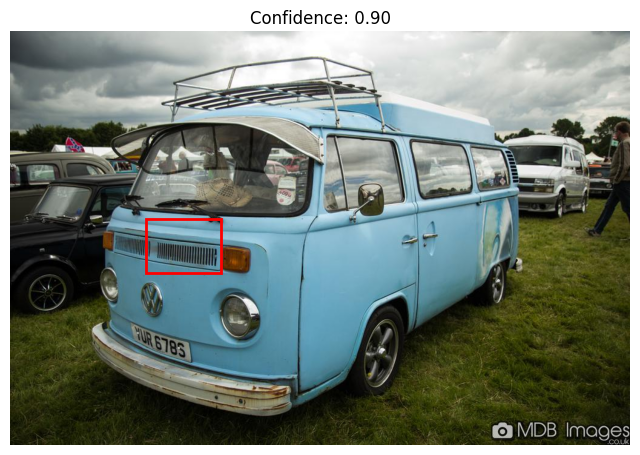

In [237]:
sample = random.choice(ds["test"])
image, box, conf = infer_single_image(model, sample)
show_prediction(image, box, conf)